# Auto-Encoders

## 1 - Convolutional AE

In [1]:
import PIL.ImageOps


## 2 - U-Net

In [1]:
import os
import PIL
import torch
import datetime
import torchvision

from torch import nn
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from skimage import io
from torchvision import transforms, utils

In [2]:
device = (
    "cuda" if torch.cuda.is_available() 
    else "cpu"
)

print(f"Using {device} device.")

Using cuda device.


In [3]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.f1 = self.create_conv_block(3, 64)
        self.p1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.f2 = self.create_conv_block(64, 128)
        self.p2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.f3 = self.create_conv_block(128, 256)
        self.p3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.f4 = self.create_conv_block(256, 512)
        self.p4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.f5 = self.create_conv_block(512, 1024)
        self.p5 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2)
        
        self.f6 = self.create_conv_block(1024, 512)
        self.p6 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2)
        
        self.f7 = self.create_conv_block(512, 256)
        self.p7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        
        self.f8 = self.create_conv_block(256, 128)
        self.p8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        self.f9 = self.create_conv_block(128, 64)
        self.p9 = nn.Conv2d(64, 3, kernel_size=1)
        
    def forward(self, x):
        x = x.to(device)
        
        f1 = self.f1(x)
        p1 = self.p1(f1)
        
        f2 = self.f2(p1)
        p2 = self.p2(f2)
        
        f3 = self.f3(p2)
        p3 = self.p3(f3)
        
        f4 = self.f4(p3)
        p4 = self.p4(f4)
        
        f5 = self.f5(p4)
        p5 = self.p5(f5)
        
        f6 = self.f6(torch.cat([f4, p5], dim=1))
        p6 = self.p6(f6)
        
        f7 = self.f7(torch.cat([f3, p6], dim=1))
        p7 = self.p7(f7)
        
        f8 = self.f8(torch.cat([f2, p7], dim=1))
        p8 = self.p8(f8)
        
        f9 = self.f9(torch.cat([f1, p8], dim=1))
        p9 = self.p9(f9)
        
        return p9
        
    def create_conv_block(self, num_channels_in, num_channels_out):
        block = nn.Sequential(
            nn.Conv2d(num_channels_in, num_channels_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_channels_out, num_channels_out, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        return block
    
    # https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
    def train_model(self, train_loader, val_loader, epochs, optimizer, loss_fn):   
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        writer = SummaryWriter(log_dir=os.path.join(Path().resolve().parents[1], f"logs\\UNet_trainer_{timestamp}"))
        
        best_v_loss = 1_000_000
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}: ")
            
            self.train(True)
            last_loss = 0
            
            for i, data in enumerate(train_loader):
                data = data.to(device)
                running_loss = 0
                
                optimizer.zero_grad()
                predictions = self(data)
                
                loss = loss_fn(predictions, data)
                loss.backward()
                
                optimizer.step()
                
                running_loss += loss.item()
                # if i % 50 == 49:
                last_loss = running_loss #/ 50
                tb_x = epoch  * len(train_loader) + i + 1
                writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0
                    
            running_v_loss = 0.0
            self.eval()
            
            with torch.no_grad():
                for i, v_data in enumerate(val_loader):
                    v_preds = self(v_data)
                    v_loss = loss_fn(v_preds, v_data)
                    running_v_loss += v_loss.item()
                    
            avg_v_loss = running_v_loss / (epoch + 1)
            print(f"    | Loss train: {last_loss}\n    | Loss validation: {avg_v_loss}")
            
            writer.add_scalars('Training vs. Validation Loss', {"Training": last_loss, "Validation": avg_v_loss}, epoch + 1)
            writer.flush()
            
            if avg_v_loss < best_v_loss:
                best_v_loss = avg_v_loss
                model_path = os.path.join(Path().resolve().parents[1], f"model_{timestamp}_{epoch}")
                torch.save(self.state_dict(), model_path)
            
        return

In [4]:
class TreemapsDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_dir = image_folder
        self.transform = transform
    
    #     https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
    def __len__(self):
        files_in_dir = next(os.walk(self.image_dir))[2]
        return len(files_in_dir)
    
    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()
            
        image = io.imread(os.path.join(self.image_dir, f"treemap_{item}.png"))
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [5]:
import matplotlib.pyplot as plt
from pathlib import Path

batch_size = 1

transform = transforms.ToTensor()
dataset_train = TreemapsDataset(image_folder=os.path.join(Path().resolve().parents[1], "outputs\\treemaps\\train"), transform=transform)
dataset_val = TreemapsDataset(image_folder=os.path.join(Path().resolve().parents[1], "outputs\\treemaps\\validation"), transform=transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

0 torch.Size([1, 3, 1500, 1500])


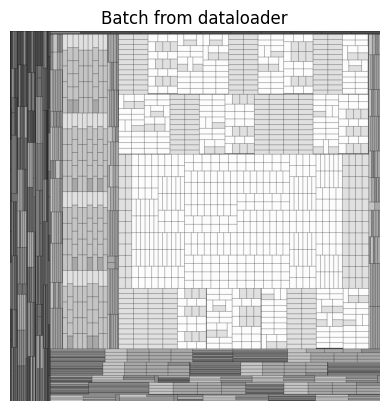

In [6]:
def show_landmarks_batch(images_batch):
    batch_size = len(images_batch)

    grid = utils.make_grid(images_batch, padding=25, pad_value=255)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):

        plt.title('Batch from dataloader')
        
for i_batch, sample_batched in enumerate(dataloader_train):
    print(i_batch, sample_batched.size())

    # observe 4th batch and stop.
    if i_batch == 0:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [7]:
unet = UNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

unet.train_model(dataloader_train, dataloader_val, 10, optimizer, loss_fn)

Epoch 1/10: 
    | Loss train: 1.9338613748550415
    | Loss validation: 0.0
Epoch 2/10: 
    | Loss train: 1.9321833848953247
    | Loss validation: 0.0
Epoch 3/10: 
    | Loss train: 2.0109384059906006
    | Loss validation: 0.0
Epoch 4/10: 
    | Loss train: 2.010826587677002
    | Loss validation: 0.0
Epoch 5/10: 
    | Loss train: 1.9318552017211914
    | Loss validation: 0.0
Epoch 6/10: 
    | Loss train: 2.452840566635132
    | Loss validation: 0.0
Epoch 7/10: 
    | Loss train: 1.9318727254867554
    | Loss validation: 0.0
Epoch 8/10: 
    | Loss train: 1.93185293674469
    | Loss validation: 0.0
Epoch 9/10: 
    | Loss train: 2.45279860496521
    | Loss validation: 0.0
Epoch 10/10: 
    | Loss train: 2.4528026580810547
    | Loss validation: 0.0
